## Packages

In [1]:
!pip -q install quantiphy numpy sympy pandas matplotlib control

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import control
import pandas as pd
from quantiphy import Quantity
from typing import List, Optional

## Utils

In [3]:
# Prints a given parameter with its unit and using multipliers
def print_param(name: str, value: float, unit: str = "") -> None:
	print(name + ": " + str(Quantity(value, unit)))

# Converts a log value to a linear value
def log_2_linear(gain: float) -> float:
	return 10.0 ** (gain / 20.0)

# Converts a linear value to a log value
def linear_2_log(gain: float) -> float:
	return 20.0 * np.log10(gain)

# Comercial EE values list
def get_EE_list(limit: int = 21, lower = 0, pack: Optional[ List[ float ] ] = None) -> List[ float ]:
	return [x * (10 ** i) for i in range(pack[1] if pack else lower, pack[0] if pack else limit) for x in [ 1.5e-12, 1.8e-12, 2.2e-12, 2.7e-12, 3.3e-12, 4.7e-12, 5.1e-12, 6.8e-12, 7.5e-12, 8.2e-12, 9.1e-12, 10e-12 ]]

def get_EE_limit_from_value(value: float) -> List[ int ]:
	order = np.floor(np.log10(value))
	return [ int(13 + order), int((13 + order) - 1) ] 


# Find the best fit for the closest comercial value in the EE list
def round_to_commercial(value: float) -> float:
	EE: List[ float ] = get_EE_list()
	index: int = 0
	close: float = np.inf
	for i, val in enumerate(EE):
		diff = val - value
		if np.abs(diff) < close:
			close = np.abs(diff)
			index = i
	return EE[index]

# Get the gain in the passing band
def get_gain(df: pd.DataFrame, col: str) -> np.float64:
	return df[col].max()

# Get the gain in the passing band
def get_gain_in_range(df: pd.DataFrame, col: str, f: float, t: float) -> np.float64:
	return df[col][f:t].max()

# Get the frequency with gain -3db of the passing band gain
def get_cutoff_frequency(df: pd.DataFrame, col: str) -> np.float64:
	# Get gains
	gain = get_gain(df, col)
	cutoff_gain = gain - 3

	index = df.index.name
	df = df.reset_index()
	# Get the two values nearest to the cutoff gain and get the frequency
	cutoff_frequencies = df.iloc[(df[col] - cutoff_gain).abs().argsort()[:2]][index]
	# Return the minimum cutoff frequency
	return cutoff_frequencies.min()

# Get the frequency with gain -3db of the passing band gain
def get_cutoff_frequency_in_range(df: pd.DataFrame, col: str, f: float, t: float) -> np.float64:
	# Get gains
	gain = get_gain_in_range(df, col, f, t)
	cutoff_gain = gain - 3

	index = df.index.name
	df = df.reset_index()
	# Get the two values nearest to the cutoff gain and get the frequency
	cutoff_frequencies = df.iloc[(df[col] - cutoff_gain).abs().argsort()[:2]][index]
	# Return the minimum cutoff frequency
	return cutoff_frequencies.min()

# Get the gain in the cutoff frequency
def get_cutoff_gain(gain: float) -> float:
	return gain - 3.0

# Create the transfer function of a theorical high pass filter
# @param freq cutoff frequency
# @param gain in the passing band
def get_n1_high_pass_filter(freq: float, gain: float) -> control.TransferFunction:
	w0 = (2 * np.pi * freq)
	'''
		High pass filter transfer function 
		gain * s / 1 + w0
	'''
	num = [gain, 0]
	den = [1, w0]
	return control.TransferFunction(num, den)

# Create the transfer function of a theorical low pass filter
# @param freq cutoff frequency
# @param gain in the passing band
def get_n1_low_pass_filter(freq: float, gain: float) -> control.TransferFunction:
	w0 = (2 * np.pi * freq)
	'''
		High pass filter transfer function 
		gain * w0 / (s + w0)
	'''
	num = [0, gain]
	den = [1 / w0, 1]
	return control.TransferFunction(num, den)

# Get the attenuation ratio of a pandas dataframe containing 
# one of the desired curves of the test
def get_attenuation_ratio(df: pd.DataFrame, gain: str, high_pass: bool = True) -> float:
	cutoff_frequency = get_cutoff_frequency(df, gain)
	# use values under 50% of the cutoff frequency to reduce the error because of the transition
	df_temp = df[df.index < (cutoff_frequency * 0.5)] if high_pass else df[df.index > (cutoff_frequency * 0.5)]
	index = df_temp.index.name
	df_temp = df_temp.reset_index()
	return np.abs((df_temp[gain].diff() / np.log10(df_temp[index]).diff()).mean())

# Create the transfer function of a theorical high pass filter
# @param freq cutoff frequency
# @param gain in the passing band
def get_n3_low_pass_filter(freq: float, gain: float, Q: float) -> control.TransferFunction:
	w1 = (2 * np.pi * freq)
	w2 = (2 * np.pi * freq)
	'''
		https://habr.com/en/post/542496/
		Low pass filter transfer function 3° Order 
								A                                 A                                 A
		H(s) = ————————————————————————— = ————————————————————————————————————— = ———————————————————————————
			(1 + a s)(1 + b s + c s²)   1 + (a + b) s + (a b + c) s² + a c s³   1 + ps1 s + ps2 s² + ps3 s³

		ps1 = 1 / ω₁ + 1 / (Q ω₂)
		ps2 = 1 / (ω₁ Q ω₂) + 1/ω₂²
		ps3 = 1 / (ω₁ ω₂²)
	'''
	ps1 = (1 / (w1 + 1)) / (Q * w2)
	ps2 = (1 / (w1 * Q * w2)) + (1 / (w2 ** 2))
	ps3 = 1 / (w1 * (w2 ** 2))
	num = [0, gain]
	den = [ps3, ps2, ps1, 1]
	return control.TransferFunction(num, den)


### 1 - Projetar e simular um filtro passa-alta de primeira ordem (VCVS)

In [4]:
# 1 - Projetar e simular um filtro passa-alta de primeira ordem [gain = 3, cut = 230Hz]

# Cut frequency in Hz
fc: float = 230

# Angular velocity
wc: float = 2 * np.pi * fc

# Linear gain
K: float = 3

# First order
b: float = 1

C_suggested = (10.0 / fc) * 1e-6
print_param("Suggested Capacitor", C_suggested, "F")

# Searches for the best component fit
last_diff: int = 9999999
res: List[ float ] = []
for C in get_EE_list(pack = get_EE_limit_from_value(C_suggested)):
	R1 = b / (wc * C)
	R3 = K * R1
	R2 = R3 / (K -1)
	R1_commercial = round_to_commercial(R1)
	R2_commercial = round_to_commercial(R2)
	R3_commercial = round_to_commercial(R3)
	total_diff = np.abs(R1_commercial - R1) + np.abs(R2_commercial - R2) + np.abs(R3_commercial - R3)
	if (total_diff < last_diff):
		last_diff = total_diff
		res = [ C, R1, R2, R3, R1_commercial, R2_commercial, R3_commercial ]

# Fetches saved value
[ C, R1, R2, R3, R1_commercial, R2_commercial, R3_commercial ] = res

print("Parameters: ")
print_param("C", C, "F")
print_param("Ideal R1", R1, "Ω")
print_param("Ideal R2", R2, "Ω")
print_param("Ideal R3", R3, "Ω")
print_param("Round R1", R1_commercial, "Ω")
print_param("Round R2", R2_commercial, "Ω")
print_param("Round R3", R3_commercial, "Ω")
print("Simulation parameters: ")
print(" - Ideal:")
print(f"\t.param C={Quantity(C)} R1={Quantity(R1)} R2={Quantity(R2)} R3={Quantity(R3)}")
print(" - Rounded to commercial:")
print(f"\t.param C={Quantity(C)} R1={Quantity(R1_commercial)} R2={Quantity(R2_commercial)} R3={Quantity(R3_commercial)}")

FC_commercial = 1 / (np.pi * 2 * C * R1_commercial)
FC_commercial_min = 1 / (np.pi * 2 * (C * 1.1) * (R1_commercial * 1.05))
FC_commercial_max = 1 / (np.pi * 2 * (C * 0.9) * (R1_commercial * 0.95))
print_param("Commercial frequency value", FC_commercial, "Hz")
print_param("Commercial frequency value (MIN)", FC_commercial_min, "Hz")
print_param("Commercial frequency value (MAX)", FC_commercial_max, "Hz")

Suggested Capacitor: 43.478 nF
Parameters: 
C: 100 nF
Ideal R1: 6.9198 kΩ
Ideal R2: 10.38 kΩ
Ideal R3: 20.759 kΩ
Round R1: 6.8 kΩ
Round R2: 10 kΩ
Round R3: 22 kΩ
Simulation parameters: 
 - Ideal:
	.param C=100n R1=6.9198k R2=10.38k R3=20.759k
 - Rounded to commercial:
	.param C=100n R1=6.8k R2=10k R3=22k
Commercial frequency value: 234.05 Hz
Commercial frequency value (MIN): 202.64 Hz
Commercial frequency value (MAX): 273.74 Hz


### 2 - Projetar e simular um filtro passa-alta de primeira ordem (VCVS)

In [5]:
# 2 - Projetar e simular um filtro passa-alta de primeira ordem [gain = 29, cut = 230Hz]

# Cut frequency in Hz
fc: float = 230

# Angular velocity
wc: float = 2 * np.pi * fc

# Linear gain
K: float = 29

# First order
b: float = 1

C_suggested = (10.0 / fc) * 1e-6
print_param("Suggested Capacitor", C_suggested, "F")

# Searches for the best component fit
last_diff: int = 9999999
res: List[ float ] = []
for C in  get_EE_list(pack = get_EE_limit_from_value(C_suggested)):
	R1 = b / (wc * C)
	R3 = K * R1
	R2 = R3 / (K -1)
	R1_commercial = round_to_commercial(R1)
	R2_commercial = round_to_commercial(R2)
	R3_commercial = round_to_commercial(R3)
	total_diff = np.abs(R1_commercial - R1) + np.abs(R2_commercial - R2) + np.abs(R3_commercial - R3)
	if (total_diff < last_diff):
		last_diff = total_diff
		res = [ C, R1, R2, R3, R1_commercial, R2_commercial, R3_commercial ]

# Fetches saved value
[ C, R1, R2, R3, R1_commercial, R2_commercial, R3_commercial ] = res

print_param("C", C, "F")
print_param("Ideal R1", R1, "Ω")
print_param("Ideal R2", R2, "Ω")
print_param("Ideal R3", R3, "Ω")
print_param("Round R1", R1_commercial, "Ω")
print_param("Round R2", R2_commercial, "Ω")
print_param("Round R3", R3_commercial, "Ω")
print("Simulation parameters: ")
print(" - Ideal:")
print(f"\t.param C={Quantity(C)} R1={Quantity(R1)} R2={Quantity(R2)} R3={Quantity(R3)}")
print(" - Rounded to commercial:")
print(f"\t.param C={Quantity(C)} R1={Quantity(R1_commercial)} R2={Quantity(R2_commercial)} R3={Quantity(R3_commercial)}")

FC_commercial = 1 / (np.pi * 2 * C * R1_commercial)
FC_commercial_min = 1 / (np.pi * 2 * (C * 1.1) * (R1_commercial * 1.05))
FC_commercial_max = 1 / (np.pi * 2 * (C * 0.9) * (R1_commercial * 0.95))
print_param("Commercial frequency value", FC_commercial, "Hz")
print_param("Commercial frequency value (MIN)", FC_commercial_min, "Hz")
print_param("Commercial frequency value (MAX)", FC_commercial_max, "Hz")

Suggested Capacitor: 43.478 nF
C: 91 nF
Ideal R1: 7.6042 kΩ
Ideal R2: 7.8757 kΩ
Ideal R3: 220.52 kΩ
Round R1: 7.5 kΩ
Round R2: 8.2 kΩ
Round R3: 220 kΩ
Simulation parameters: 
 - Ideal:
	.param C=91n R1=7.6042k R2=7.8757k R3=220.52k
 - Rounded to commercial:
	.param C=91n R1=7.5k R2=8.2k R3=220k
Commercial frequency value: 233.19 Hz
Commercial frequency value (MIN): 201.9 Hz
Commercial frequency value (MAX): 272.74 Hz


### 3 - Projetar e simular um filtro passa-baixa de primeira ordem (VCVS)

In [6]:
# 3 - Projetar e simular um filtro passa-baixa de primeira ordem [gain = 29, cut = 10kHz]

# Cut frequency in Hz
fc: float = 10e3

# Angular velocity
wc: float = 2 * np.pi * fc

# Linear gain
K: float = 29

# First order
b: float = 1

C_suggested = (10.0 / fc) * 1e-6
print_param("Suggested Capacitor", C_suggested, "F")

# Searches for the best component fit cap
last_diff: int = 9999999
res: List[ float ] = []
for C in get_EE_list(pack = get_EE_limit_from_value(C_suggested)):
	R1 = 1 / (b * wc * C)
	R3 = K * R1
	R2 = R3 / (K -1)
	R1_commercial = round_to_commercial(R1)
	R2_commercial = round_to_commercial(R2)
	R3_commercial = round_to_commercial(R3)
	total_diff = np.abs(R1_commercial - R1) + np.abs(R2_commercial - R2) + np.abs(R3_commercial - R3)
	if (total_diff < last_diff):
		last_diff = total_diff
		res = [ C, R1, R2, R3, R1_commercial, R2_commercial, R3_commercial ]

# Fetches saved value
[ C, R1, R2, R3, R1_commercial, R2_commercial, R3_commercial ] = res

print_param("C", C, "F")
print_param("Ideal R1", R1, "Ω")
print_param("Ideal R2", R2, "Ω")
print_param("Ideal R3", R3, "Ω")
print_param("Round R1", R1_commercial, "Ω")
print_param("Round R2", R2_commercial, "Ω")
print_param("Round R3", R3_commercial, "Ω")
print("Simulation parameters: ")
print(" - Ideal:")
print(f"\t.param C={Quantity(C)} R1={Quantity(R1)} R2={Quantity(R2)} R3={Quantity(R3)}")
print(" - Rounded to commercial:")
print(f"\t.param C={Quantity(C)} R1={Quantity(R1_commercial)} R2={Quantity(R2_commercial)} R3={Quantity(R3_commercial)}")

FC_commercial = 1 / (np.pi * 2 * C * R1_commercial)
FC_commercial_min = 1 / (np.pi * 2 * (C * 1.1) * (R1_commercial * 1.05))
FC_commercial_max = 1 / (np.pi * 2 * (C * 0.9) * (R1_commercial * 0.95))
print_param("Commercial frequency value", FC_commercial, "Hz")
print_param("Commercial frequency value (MIN)", FC_commercial_min, "Hz")
print_param("Commercial frequency value (MAX)", FC_commercial_max, "Hz")

Suggested Capacitor: 1 nF
C: 9.1 nF
Ideal R1: 1.749 kΩ
Ideal R2: 1.8114 kΩ
Ideal R3: 50.72 kΩ
Round R1: 1.8 kΩ
Round R2: 1.8 kΩ
Round R3: 51 kΩ
Simulation parameters: 
 - Ideal:
	.param C=9.1n R1=1.749k R2=1.8114k R3=50.72k
 - Rounded to commercial:
	.param C=9.1n R1=1.8k R2=1.8k R3=51k
Commercial frequency value: 9.7164 kHz
Commercial frequency value (MIN): 8.4125 kHz
Commercial frequency value (MAX): 11.364 kHz


### 4 - Projetar e simular um filtro passa-baixa de terceira ordem (Chebyshev) (VCVS)

In [7]:
# 4 - Projetar e simular um filtro passa-baixa de terceira ordem 2db [gain = 29, cut = 10kHz]

# Cut frequency in Hz
fc: float = 10e3

# Angular velocity
wc: float = 2 * np.pi * fc

# Total gain
total_k: float = linear_2_log(29)

# Per stage gain
K: float = np.sqrt(total_k)

# First stage for 3dB
a0: float = 0.298620
b0: float = 0.839174

# Second stage for 3dB
a1: float = 0.298620

C_suggested = (10.0 / fc) * 1e-6
print_param("Suggested Capacitor", C_suggested, "F")

#
# First stage low pass calcs order 2
#

# Searches for the best component fit cap
last_diff: int = 9999999
res: List[ float ] = []
for C in  get_EE_list(pack = get_EE_limit_from_value(C_suggested)):
	C2: float = C
	C1: float = (((a0 ** 2) + (4 * b0 * (K - 1))) * C2) / (4 * b0)
	C1_commercial: float = round_to_commercial(C1)

	aux = (((a0 ** 2) + (4 * b0 * (K - 1))) * (C2 ** 2)) - (4 * b0 * C1 * C2)

	if aux < 0:
		continue

	R1: float = 2.0 / (((a0 * C2) + np.sqrt(aux)) * wc)

	R2: float = 1.0 / (b0 * C1 * C2 * R1 * (wc ** 2))

	R3: float = (K * (R1 + R2)) / (K - 1)

	R4: float = K * (R1 + R2)

	R1_commercial = round_to_commercial(R1)
	R2_commercial = round_to_commercial(R2)
	R3_commercial = round_to_commercial(R3)
	R4_commercial = round_to_commercial(R4)
	total_diff = np.abs(R1_commercial - R1) + np.abs(R2_commercial - R2) + np.abs(R3_commercial - R3) + np.abs(R4_commercial - R4) + np.abs(C1_commercial - C1)
	if (total_diff < last_diff):
		last_diff = total_diff
		res = [ C1, C2, R1, R2, R3, R4, R1_commercial, R2_commercial, R3_commercial, C1_commercial ]

# Fetches saved value
[ C1, C2, R1, R2, R3, R4, R1_commercial, R2_commercial, R3_commercial, C1_commercial ] = res

print("First stage (Low Pass Order 2)")
print_param("C2", C2, "F")
print_param("Ideal C1", C1, "F")
print_param("Ideal R1", R1, "Ω")
print_param("Ideal R2", R2, "Ω")
print_param("Ideal R3", R3, "Ω")
print_param("Ideal R4", R4, "Ω")
print_param("Round C1", C1_commercial, "F")
print_param("Round R1", R1_commercial, "Ω")
print_param("Round R2", R2_commercial, "Ω")
print_param("Round R3", R3_commercial, "Ω")
print_param("Round R4", R4_commercial, "Ω")

print("Simulation parameters: ")
print(" - Ideal:")
print(f"\t.param C1_0={Quantity(C1)} C2_0={Quantity(C2)} R1_0={Quantity(R1)} R2_0={Quantity(R2)} R3_0={Quantity(R3)} R4_0={Quantity(R4)}")
print(" - Rounded to commercial:")
print(f"\t.param C1_0={Quantity(C1_commercial)} C2_0={Quantity(C2)} R1_0={Quantity(R1_commercial)} R2_0={Quantity(R2_commercial)} R3_0={Quantity(R3_commercial)} R4_0={Quantity(R4_commercial)}")

# Seconds stage low pass calcs order 1

# Searches for the best component fit till 10nF cap
last_diff: int = 9999999
res: List[ float ] = []
for C in  get_EE_list(pack = get_EE_limit_from_value(C_suggested)):
	R1 = 1 / (b * wc * C)
	R3 = K * R1
	R2 = R3 / (K -1)
	R1_commercial = round_to_commercial(R1)
	R2_commercial = round_to_commercial(R2)
	R3_commercial = round_to_commercial(R3)
	total_diff = np.abs(R1_commercial - R1) + np.abs(R2_commercial - R2) + np.abs(R3_commercial - R3)
	if (total_diff < last_diff):
		last_diff = total_diff
		res = [ C, R1, R2, R3, R1_commercial, R2_commercial, R3_commercial ]

# Fetches saved value
[ C, R1, R2, R3, R1_commercial, R2_commercial, R3_commercial ] = res

print("\nSecond stage (Low Pass Order 1)")
print_param("C", C, "F")
print_param("Ideal R1", R1, "Ω")
print_param("Ideal R2", R2, "Ω")
print_param("Ideal R3", R3, "Ω")
print_param("Round R1", R1_commercial, "Ω")
print_param("Round R2", R2_commercial, "Ω")
print_param("Round R3", R3_commercial, "Ω")
print("Simulation parameters: ")
print(" - Ideal:")
print(f"\t.param C1_1={Quantity(C)} R1_1={Quantity(R1)} R2_1={Quantity(R2)} R3_1={Quantity(R3)}")
print(" - Rounded to commercial:")
print(f"\t.param C1_1={Quantity(C)} R1_1={Quantity(R1_commercial)} R2_1={Quantity(R2_commercial)} R3_1={Quantity(R3_commercial)}")

Suggested Capacitor: 1 nF
First stage (Low Pass Order 2)
C2: 6.8 nF
Ideal C1: 30.156 nF
Ideal R1: 15.676 kΩ
Ideal R2: 93.904 Ω
Ideal R3: 19.347 kΩ
Ideal R4: 85.283 kΩ
Round C1: 33 nF
Round R1: 15 kΩ
Round R2: 91 Ω
Round R3: 18 kΩ
Round R4: 51 kΩ
Simulation parameters: 
 - Ideal:
	.param C1_0=30.156n C2_0=6.8n R1_0=15.676k R2_0=93.904 R3_0=19.347k R4_0=85.283k
 - Rounded to commercial:
	.param C1_0=33n C2_0=6.8n R1_0=15k R2_0=91 R3_0=18k R4_0=51k

Second stage (Low Pass Order 1)
C: 9.1 nF
Ideal R1: 1.749 kΩ
Ideal R2: 2.1457 kΩ
Ideal R3: 9.4586 kΩ
Round R1: 1.8 kΩ
Round R2: 2.2 kΩ
Round R3: 9.1 kΩ
Simulation parameters: 
 - Ideal:
	.param C1_1=9.1n R1_1=1.749k R2_1=2.1457k R3_1=9.4586k
 - Rounded to commercial:
	.param C1_1=9.1n R1_1=1.8k R2_1=2.2k R3_1=9.1k


# Circuitos e Análises


## 1- Filtro passa-alta de primeira ordem [gain = 3, cut = 230Hz] (VCVS)

<img src="./analises/1/1.png"/>
<hr/>

Circuito:

	- Ideal:
		C=100nF
		R1=6.9198kΩ
		R2=10.38kΩ
		R3=20.759kΩ
	- Comercial:
		C=100nF
		R1=6.8kΩ
		R2=10kΩ
		R3=22kΩ
Parâmetros:

	- Alimentação do ampop:
		Vcc = 15V Vee = -15V
	- Sinal de entrada:
		Vpp = 100mV
		Fase = 0°
Análise:

	- Transiente:
		De 1Hz até 200MHz

<hr />

### Teóricas e simuladas

- Gain Theoretical: 9.5424 db
- Gain Theoretical: 3


- Gain TL082: 9.5404 db
- Gain TL082: 2.9993


- Gain LM324: 9.5405 db
- Gain LM324: 2.9993


Cutoff frequency theoretical: 230 Hz
Cutoff frequency TL082: 230.5 Hz
Cutoff frequency LM324: 230.5 Hz


Cutoff frequency phase theoretical: 45°
Cutoff frequency phase TL082: 44.926°
Cutoff frequency phase LM324: 44.917°


Attenuation ratio theoretical: 20 db/dec
Attenuation ratio TL082: 19.528 db/dec
Attenuation ratio LM324: 19.528 db/dec


Cutoff frequency gain theoretical: 6.5424 db
Cutoff frequency gain TL082: 6.541 db
Cutoff frequency gain LM324: 6.5411 db


Text(0.5, 0, 'Frequency (Hz)')

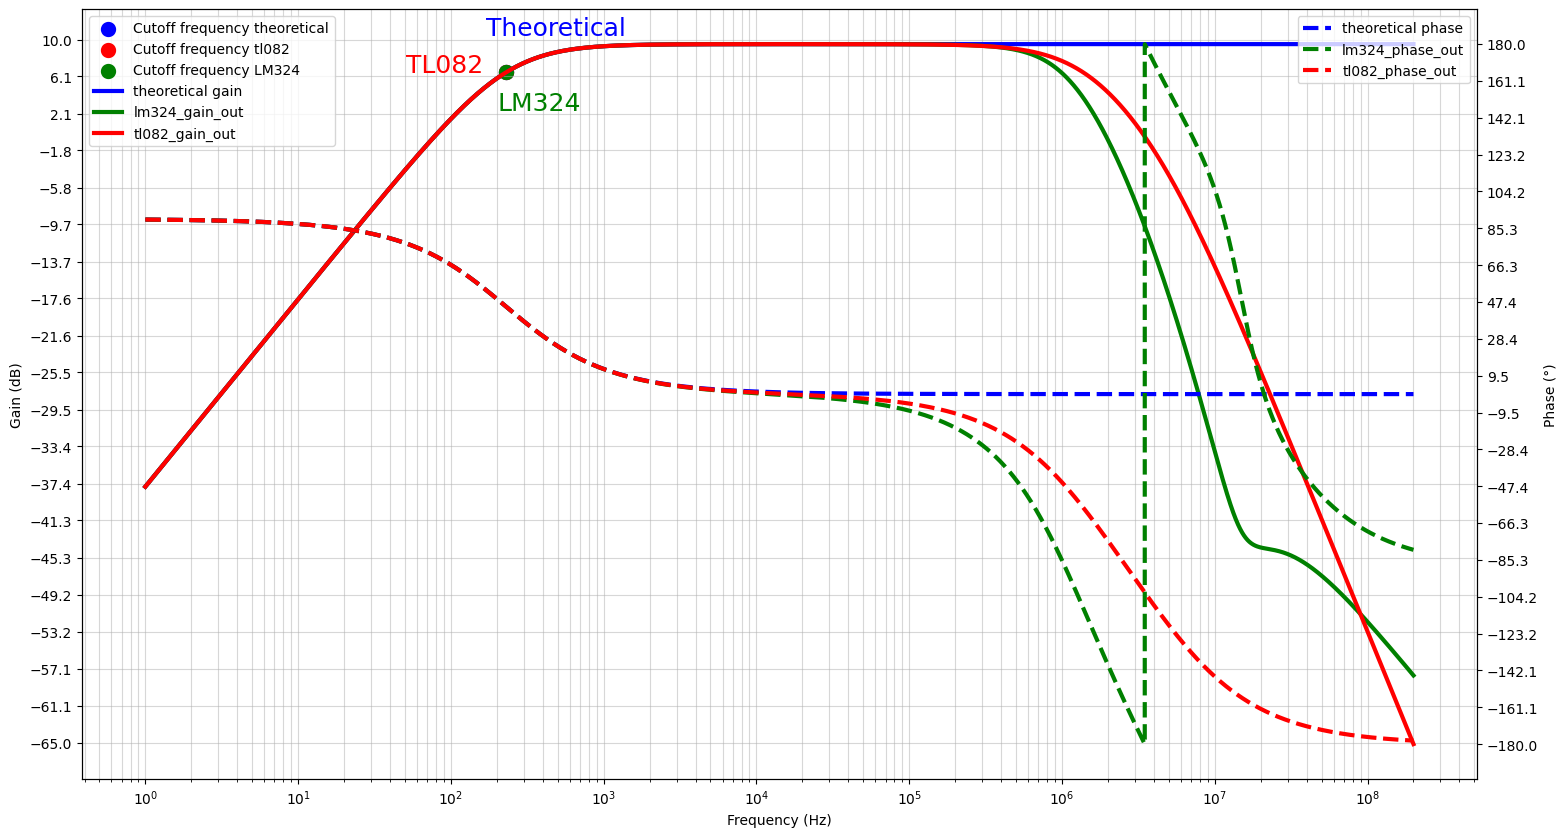

In [8]:
doc = pd.DataFrame(pd.read_csv("./analises/1/1.txt", index_col = "frequency"))


linear_gain_theoretical = 3
gain_theoretical = linear_2_log(linear_gain_theoretical)
gain_tl082 = get_gain(doc, "tl082_gain_out")
gain_lm324 = get_gain(doc, "lm324_gain_out")

cutoff_frequency_theoretical = 230
cutoff_frequency_tl082 = get_cutoff_frequency(doc, "tl082_gain_out")
cutoff_frequency_lm324 = get_cutoff_frequency(doc, "lm324_gain_out")

attenuation_ratio_tl082 = get_attenuation_ratio(doc, "tl082_gain_out")
attenuation_ratio_lm324 = get_attenuation_ratio(doc, "lm324_gain_out")

# Create transfer function of the theoretical behavior 
theoretical_tf = get_n1_high_pass_filter(cutoff_frequency_theoretical, linear_gain_theoretical)

print_param("- Gain Theoretical", gain_theoretical, "db")
print_param("- Gain Theoretical", linear_gain_theoretical, "")
print("\n")
print_param("- Gain TL082", gain_tl082, "db")
print_param("- Gain TL082", log_2_linear(gain_tl082), "")
print("\n")
print_param("- Gain LM324", gain_lm324, "db")
print_param("- Gain LM324", log_2_linear(gain_lm324), "")
print("\n")
print_param("Cutoff frequency theoretical", cutoff_frequency_theoretical, "Hz")
print_param("Cutoff frequency TL082", cutoff_frequency_tl082, "Hz")
print_param("Cutoff frequency LM324", cutoff_frequency_lm324, "Hz")
print("\n")
print_param("Cutoff frequency phase theoretical", 45, "°")
print_param("Cutoff frequency phase TL082", doc.loc[cutoff_frequency_tl082]["tl082_phase_out"], "°")
print_param("Cutoff frequency phase LM324", doc.loc[cutoff_frequency_lm324]["lm324_phase_out"], "°")
print("\n")
print_param("Attenuation ratio theoretical", 20, "db/dec")
print_param("Attenuation ratio TL082", attenuation_ratio_tl082, "db/dec")
print_param("Attenuation ratio LM324", attenuation_ratio_lm324, "db/dec")
print("\n")
print_param("Cutoff frequency gain theoretical", gain_theoretical - 3, "db")
print_param("Cutoff frequency gain TL082", doc.loc[cutoff_frequency_tl082]["tl082_gain_out"], "db")
print_param("Cutoff frequency gain LM324", doc.loc[cutoff_frequency_lm324]["lm324_gain_out"], "db")

fig, ax = plt.subplots(figsize = (18, 10))

mag, phase, omega = theoretical_tf.frequency_response(2 * np.pi * doc.index)

freq = omega / (2 * np.pi)

# Plot cutoff frequencies
# Theoretical
ax.scatter(
	x = cutoff_frequency_theoretical,
	y = get_cutoff_gain(gain_theoretical),
	label = "Cutoff frequency theoretical",
	color = 'b',
	linewidths = 5
)
ax.annotate(
	"Theoretical",
	(cutoff_frequency_theoretical - 60, get_cutoff_gain(gain_theoretical) + 4),
	color = 'b',
	fontsize = 18
)
# TL082
ax.scatter(
	x = cutoff_frequency_tl082,
	y = get_cutoff_gain(gain_tl082),
	label = "Cutoff frequency tl082",
	color = 'r',
	linewidths = 5
)
ax.annotate(
	"TL082",
	(cutoff_frequency_tl082 - 180, get_cutoff_gain(gain_tl082)),
	color = 'r',
	fontsize = 18
)
# LM324
ax.scatter(
	x = cutoff_frequency_lm324,
	y = get_cutoff_gain(gain_lm324),
	label = "Cutoff frequency LM324",
	color = 'g',
	linewidths = 5
)
ax.annotate(
	'LM324',
	(cutoff_frequency_lm324 - 30, get_cutoff_gain(gain_lm324) - 4),
	color = 'g',
	fontsize = 18
)

# plot gain
ax.plot(
	freq,
	linear_2_log(mag),
	label = "theoretical gain",
	color = "b",
	linewidth = 3.0
)

doc.plot(
	ax = ax,
	y = ["lm324_gain_out", "tl082_gain_out"],
	color = ["g", "r"],
	lw = 3.0,
)

# plot phases
ax2 = ax.twinx()

ax2.plot(
	freq,
	np.rad2deg(np.array(phase)),
	label = "theoretical phase",
	color = "b",
	linestyle = "--",
	linewidth = 3.0
)

doc.plot(
	ax = ax2,
	y = ["lm324_phase_out", "tl082_phase_out"],
	style = ["--", "--"],
	color = ["g", "r"],
	lw = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_yticks(np.round(np.linspace(-65, 10, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)
ax.set_xlabel("Frequency (Hz)")


### Prática

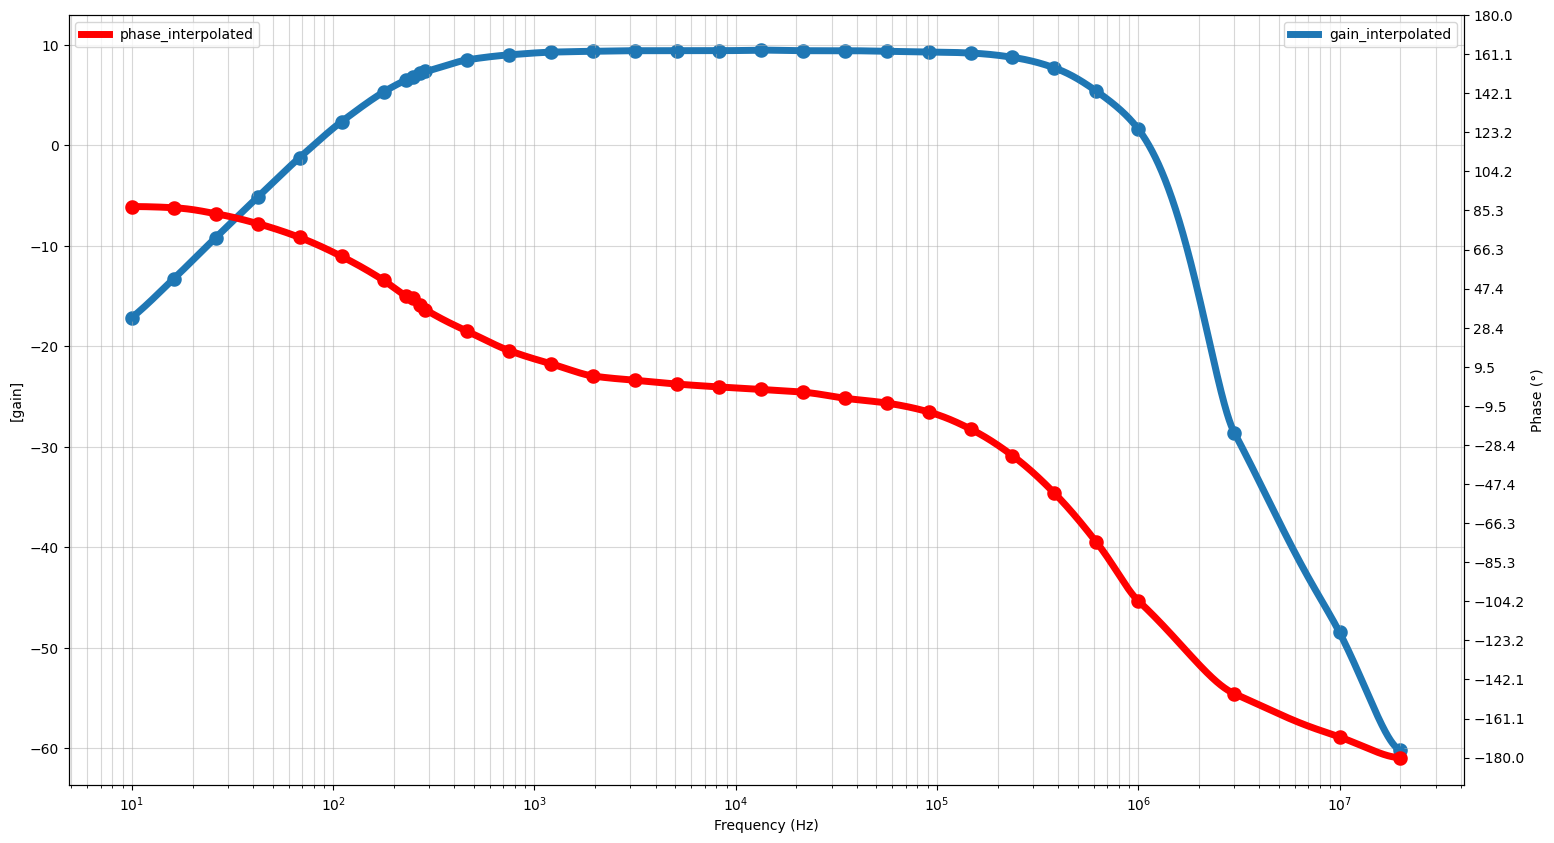

In [29]:
from scipy import interpolate

df_experiment = pd.DataFrame(
	pd.read_csv("./analises/pratica/pratica.csv", index_col = "frequency")
)
df_experiment["linear_gain"] = df_experiment["vopp"] / df_experiment["vipp"]
df_experiment["gain"] = linear_2_log(df_experiment["linear_gain"])


new_index = np.logspace(1, np.round(np.log10(20e6), 3), 61000)
interpolated_gain = interpolate.pchip_interpolate(
	df_experiment.index, df_experiment.gain, new_index
)
interpolated_phase = interpolate.pchip_interpolate(
	df_experiment.index, df_experiment.phase, new_index
)

fig, ax = plt.subplots(figsize = (18, 10))

# Plotting gain interpolation
df_experiment.reset_index().plot.scatter(ax = ax,x = "frequency" , y = ["gain"], linewidth = 6)
ax.plot(new_index, interpolated_gain, label = "gain_interpolated", lw = 5)

# Plotting phase interpolation
ax2 = ax.twinx()
df_experiment.reset_index().plot.scatter(ax = ax2,x = "frequency" , y = ["phase"], color = 'r', linewidth = 6)
ax2.plot(new_index, interpolated_phase, label = "phase_interpolated", color = 'r', lw = 5)

# configure X axis
ax.legend()
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)
ax.set_xlabel("Frequency (Hz)")

ax2.legend(loc="upper left")
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)

# creating interpolated dataframe
df_experiment = pd.DataFrame(
	{
		"gain": interpolated_gain,
		"phase": interpolated_phase,
		"frequency": new_index
	},
)
df_experiment = df_experiment.set_index("frequency")


### Comparação (TL082) - Teórica / Simulada / Prática

- Gain Theoretical: 9.5424 db
- Gain Theoretical: 3


- Gain Spice: 9.5404 db
- Gain Spice: 2.9993


- Gain experiment: 9.4855 db
- Gain experiment: 2.9804


Cutoff frequency theoretical: 230 Hz
Cutoff frequency Spice: 230.5 Hz
Cutoff frequency experiment: 228.27 Hz


Cutoff frequency phase theoretical: 45°
Cutoff frequency phase Spice: 44.926°
Cutoff frequency phase experiment: 44.154°


Attenuation ratio theoretical: 20 db/dec
Attenuation ratio Spice: 19.528 db/dec
Attenuation ratio experiment: 18.661 db/dec


Cutoff frequency gain theoretical: 6.5424 db
Cutoff frequency gain Spice: 6.541 db
Cutoff frequency gain experiment: 6.4854 db


Text(0.5, 0, 'Frequency (Hz)')

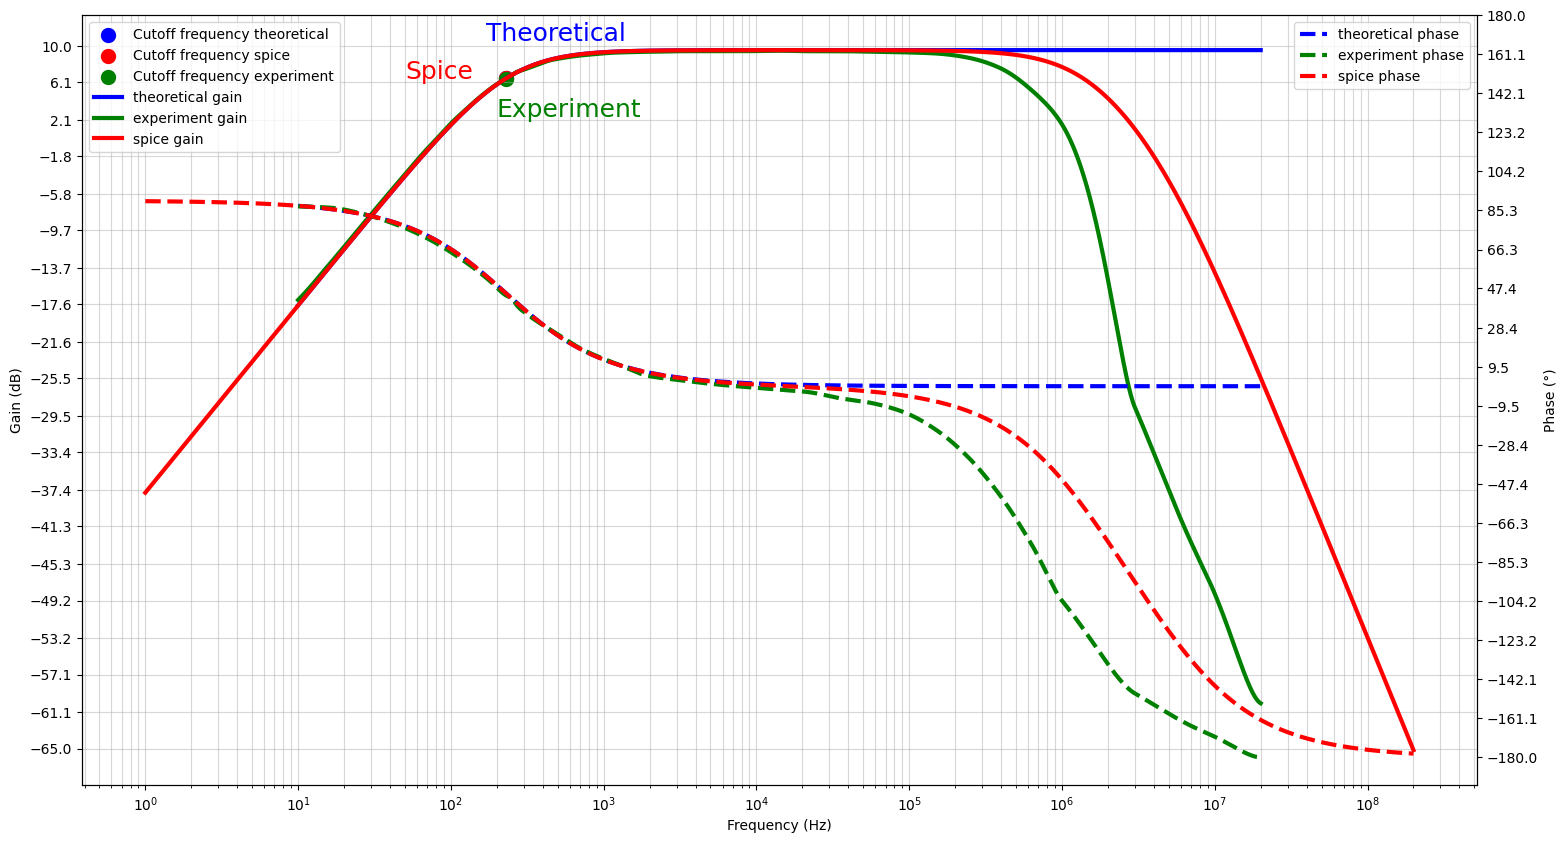

In [10]:
df_spice = pd.DataFrame(pd.read_csv("./analises/1/1.txt", index_col = "frequency"))

linear_gain_theoretical = 3
gain_theoretical = linear_2_log(linear_gain_theoretical)
gain_spice = get_gain(df_spice, "tl082_gain_out")
gain_experiment = get_gain(df_experiment, "gain")

cutoff_frequency_theoretical = 230
cutoff_frequency_spice = get_cutoff_frequency(df_spice, "tl082_gain_out")
cutoff_frequency_experiment = get_cutoff_frequency(df_experiment, "gain")

attenuation_ratio_spice = get_attenuation_ratio(df_spice, "tl082_gain_out")
attenuation_ratio_experiment = get_attenuation_ratio(df_experiment, "gain")

# Create transfer function of the theoretical behavior 
theoretical_tf = get_n1_high_pass_filter(cutoff_frequency_theoretical, linear_gain_theoretical)

print_param("- Gain Theoretical", gain_theoretical, "db")
print_param("- Gain Theoretical", linear_gain_theoretical, "")
print("\n")
print_param("- Gain Spice", gain_tl082, "db")
print_param("- Gain Spice", log_2_linear(gain_tl082), "")
print("\n")
print_param("- Gain experiment", gain_experiment, "db")
print_param("- Gain experiment", log_2_linear(gain_experiment), "")
print("\n")
print_param("Cutoff frequency theoretical", cutoff_frequency_theoretical, "Hz")
print_param("Cutoff frequency Spice", cutoff_frequency_spice, "Hz")
print_param("Cutoff frequency experiment", cutoff_frequency_experiment, "Hz")
print("\n")
print_param("Cutoff frequency phase theoretical", 45, "°")
print_param("Cutoff frequency phase Spice", df_spice.loc[cutoff_frequency_spice]["tl082_phase_out"], "°")
print_param("Cutoff frequency phase experiment", df_experiment.loc[cutoff_frequency_experiment]["phase"], "°")
print("\n")
print_param("Attenuation ratio theoretical", 20, "db/dec")
print_param("Attenuation ratio Spice", attenuation_ratio_spice, "db/dec")
print_param("Attenuation ratio experiment", attenuation_ratio_experiment, "db/dec")
print("\n")
print_param("Cutoff frequency gain theoretical", gain_theoretical - 3, "db")
print_param("Cutoff frequency gain Spice", df_spice.loc[cutoff_frequency_spice]["tl082_gain_out"], "db")
print_param("Cutoff frequency gain experiment", df_experiment.loc[cutoff_frequency_experiment]["gain"], "db")

fig, ax = plt.subplots(figsize = (18, 10))

mag, phase, omega = theoretical_tf.frequency_response(2 * np.pi * df_experiment.index)

freq = omega / (2 * np.pi)

# Plot cutoff frequencies
# Theoretical
ax.scatter(
	x = cutoff_frequency_theoretical,
	y = get_cutoff_gain(gain_theoretical),
	label = "Cutoff frequency theoretical",
	color = 'b',
	linewidths = 5
)
ax.annotate(
	"Theoretical",
	(cutoff_frequency_theoretical - 60, get_cutoff_gain(gain_theoretical) + 4),
	color = 'b',
	fontsize = 18
)
# Spice
ax.scatter(
	x = cutoff_frequency_spice,
	y = get_cutoff_gain(gain_spice),
	label = "Cutoff frequency spice",
	color = 'r',
	linewidths = 5
)
ax.annotate(
	"Spice",
	(cutoff_frequency_spice - 180, get_cutoff_gain(gain_spice)),
	color = 'r',
	fontsize = 18
)
ax.scatter(
	x = cutoff_frequency_experiment,
	y = get_cutoff_gain(gain_experiment),
	label = "Cutoff frequency experiment",
	color = 'g',
	linewidths = 5
)
ax.annotate(
	'Experiment',
	(cutoff_frequency_experiment - 30, get_cutoff_gain(gain_experiment) - 4),
	color = 'g',
	fontsize = 18
)

# plot gain
ax.plot(
	freq,
	linear_2_log(mag),
	label = "theoretical gain",
	color = "b",
	linewidth = 3.0)

df_experiment.plot(
	ax = ax,
	y = ["gain"],
	label = ["experiment gain"],
	color = ["g"],
	lw = 3.0,
)

df_spice.plot(
	ax = ax,
	y = ["tl082_gain_out"],
	label = ["spice gain"],
	color = ["r"],
	lw = 3.0,
)


# plot phases
ax2 = ax.twinx()

ax2.plot(
	freq,
	np.rad2deg(np.array(phase)),
	label = "theoretical phase",
	color = "b",
	linestyle = "--",
	linewidth = 3.0
)

df_experiment.plot(
	ax = ax2,
	y = ["phase"],
	label = ["experiment phase"],
	style = ["--"],
	color = ["g"],
	lw = 3.0
)

df_spice.plot(
	ax = ax2,
	y = ["tl082_phase_out"],
	label = ["spice phase"],
	style = ["--"],
	color = ["r"],
	lw = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_yticks(np.round(np.linspace(-65, 10, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base=10)
ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
ax.xaxis.set_minor_locator(LogLocator(
	base=10.0, subs=np.arange(0.1, 1.0, 0.1), numticks=150))
ax.set_xlabel("Frequency (Hz)")


### Ganho antes da parte ativa

Text(0.5, 0, 'Frequency (Hz)')

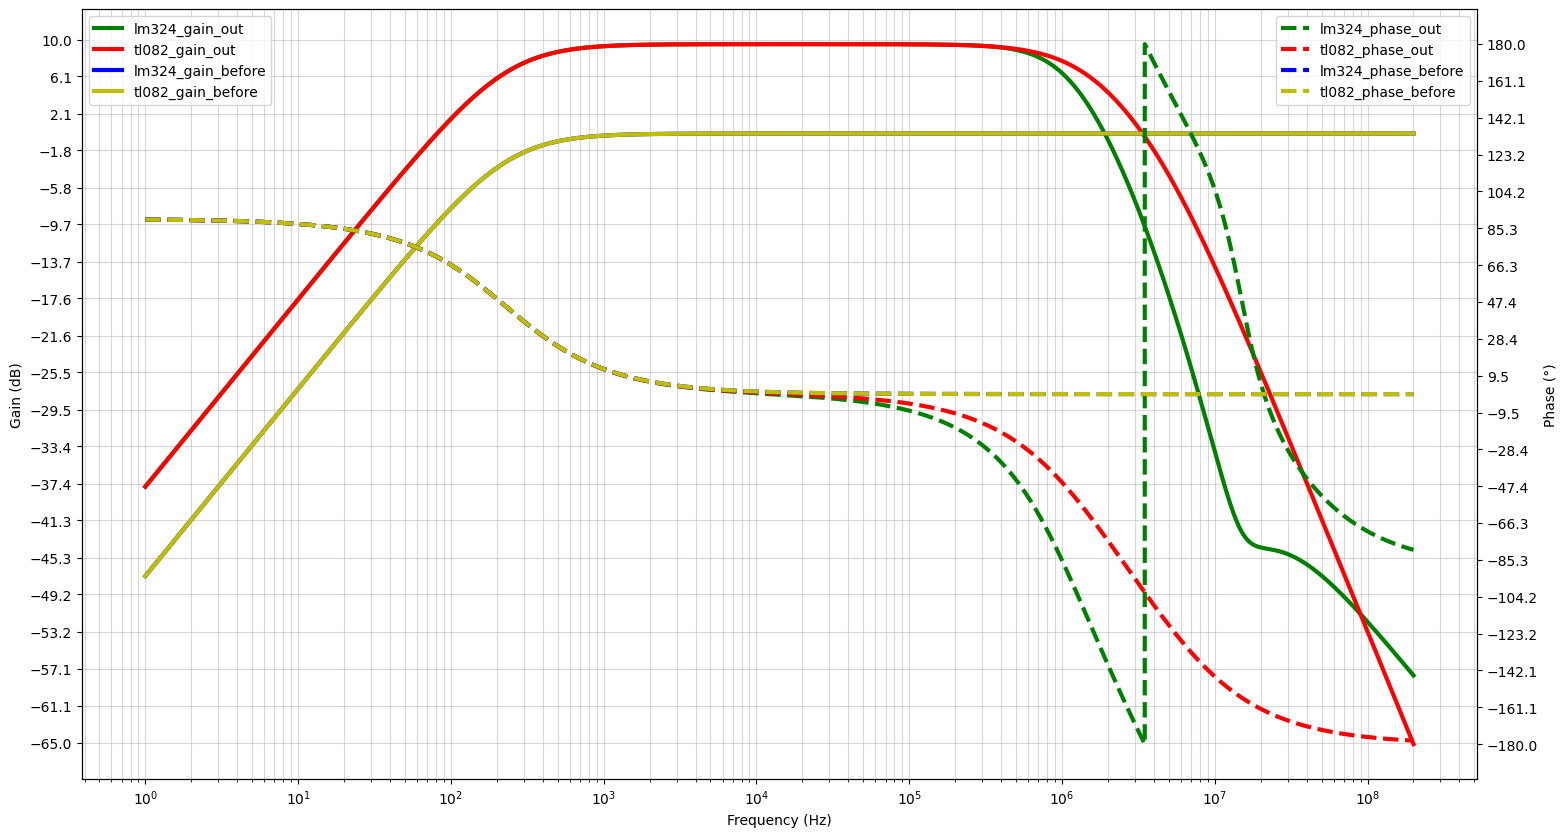

In [11]:
doc = pd.DataFrame(pd.read_csv("./analises/1/1.txt", index_col = "frequency"))

fig, ax = plt.subplots(figsize = (18, 10))

# plot gain
doc.plot(
	ax = ax,
	y = ["lm324_gain_out", "tl082_gain_out", "lm324_gain_before", "tl082_gain_before"],
	color = ["g", "r", "b", "y"],
	lw = 3.0,
)

# plot phases
ax2 = ax.twinx()

doc.plot(
	ax = ax2,
	y = ["lm324_phase_out", "tl082_phase_out", "lm324_phase_before", "tl082_phase_before"],
	style = ["--", "--", "--", "--"],
	color = ["g", "r", "b", "y"],
	lw = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_yticks(np.round(np.linspace(-65, 10, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)
ax.set_xlabel("Frequency (Hz)")


## 2 - Filtro passa-alta de primeira ordem [gain = 29, cut = 230Hz] (VCVS)

<img src="./analises/2/2.png"/>
<hr/>

Circuito:

	- Ideal:
		C=91nF
		R1=7.6042kΩ
		R2=7.8757kΩ
		R3=220.52kΩ
	- Comercial:
		C=91nF
		R1=7.5kΩ
		R2=8.2kΩ
		R3=220kΩ
Parâmetros:

	- Alimentação do ampop:
		Vcc = 15V Vee = -15V
	- Sinal de entrada:
		Vpp = 100mV
		Fase = 0°
Análise:

	- Transiente:
		De 1Hz até 200MHz

<hr />

### Teóricas e simuladas

- Gain Theoretical: 29.248 db
- Gain Theoretical: 29


- Gain TL082: 29.23 db
- Gain TL082: 28.941


- Gain LM324: 29.206 db
- Gain LM324: 28.859


Cutoff frequency theoretical: 230 Hz
Cutoff frequency TL082: 229.65 Hz
Cutoff frequency LM324: 228.51 Hz


Cutoff frequency phase theoretical: 45°
Cutoff frequency phase TL082: 44.933°
Cutoff frequency phase LM324: 44.929°


Attenuation ratio theoretical: 20 db/dec
Attenuation ratio TL082: 19.531 db/dec
Attenuation ratio LM324: 19.534 db/dec


Cutoff frequency gain theoretical: 26.248 db
Cutoff frequency gain TL082: 26.23 db
Cutoff frequency gain LM324: 26.206 db


Text(0.5, 0, 'Frequency (Hz)')

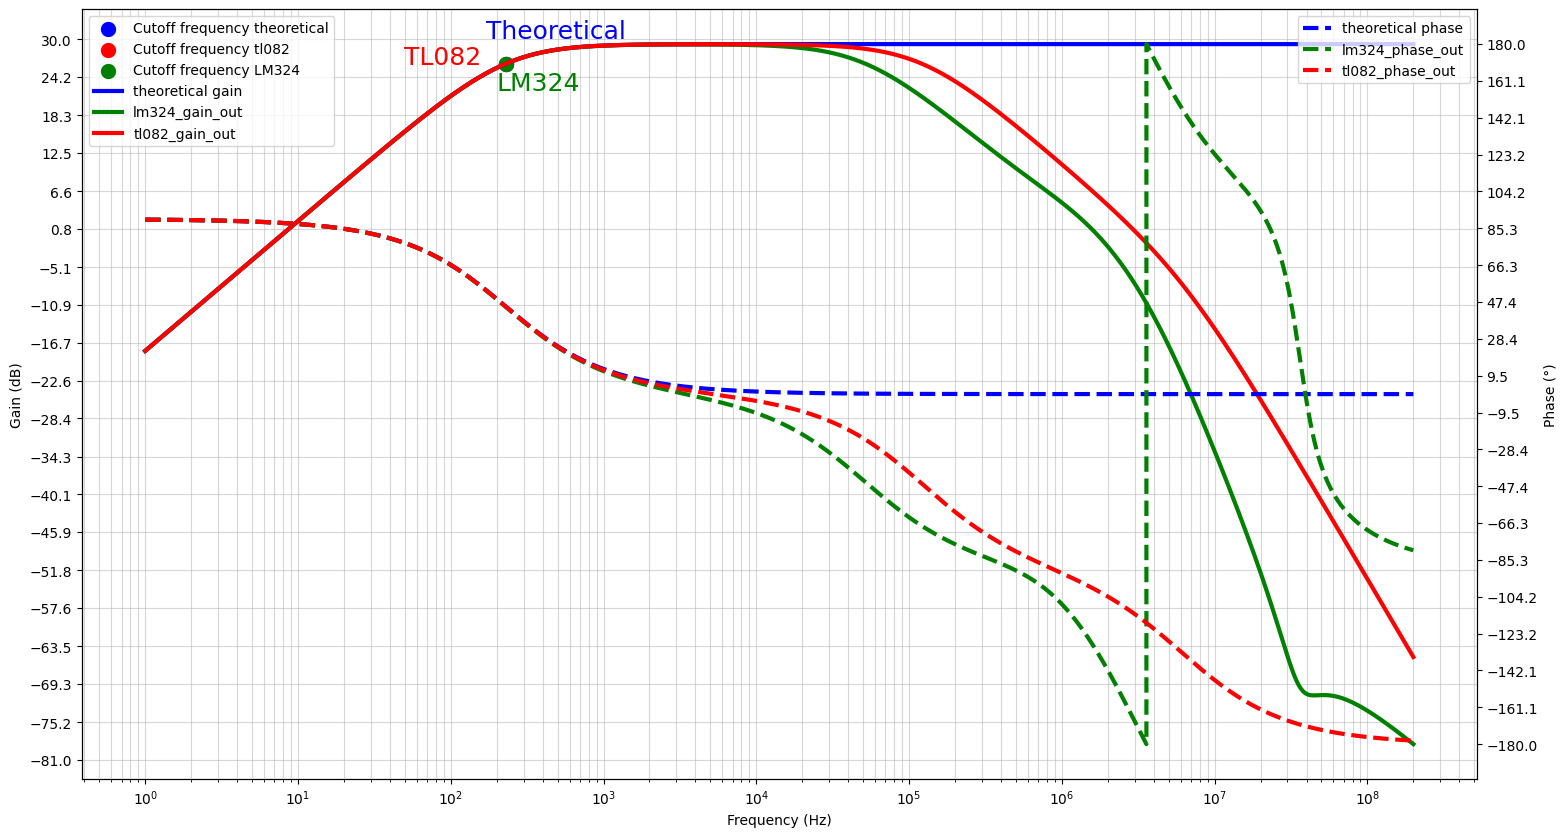

In [12]:
doc = pd.DataFrame(pd.read_csv("./analises/2/2.txt", index_col = "frequency"))

linear_gain_theoretical = 29
gain_theoretical = linear_2_log(linear_gain_theoretical)
gain_tl082 = get_gain(doc, "tl082_gain_out")
gain_lm324 = get_gain(doc, "lm324_gain_out")

cutoff_frequency_theoretical = 230
cutoff_frequency_tl082 = get_cutoff_frequency(doc, "tl082_gain_out")
cutoff_frequency_lm324 = get_cutoff_frequency(doc, "lm324_gain_out")

attenuation_ratio_tl082 = get_attenuation_ratio(doc, "tl082_gain_out")
attenuation_ratio_lm324 = get_attenuation_ratio(doc, "lm324_gain_out")

# Create transfer function of the theoretical behavior 
theoretical_tf = get_n1_high_pass_filter(cutoff_frequency_theoretical, linear_gain_theoretical)

print_param("- Gain Theoretical", gain_theoretical, "db")
print_param("- Gain Theoretical", linear_gain_theoretical, "")
print("\n")
print_param("- Gain TL082", gain_tl082, "db")
print_param("- Gain TL082", log_2_linear(gain_tl082), "")
print("\n")
print_param("- Gain LM324", gain_lm324, "db")
print_param("- Gain LM324", log_2_linear(gain_lm324), "")
print("\n")
print_param("Cutoff frequency theoretical", cutoff_frequency_theoretical, "Hz")
print_param("Cutoff frequency TL082", cutoff_frequency_tl082, "Hz")
print_param("Cutoff frequency LM324", cutoff_frequency_lm324, "Hz")
print("\n")
print_param("Cutoff frequency phase theoretical", 45, "°")
print_param("Cutoff frequency phase TL082", doc.loc[cutoff_frequency_tl082]["tl082_phase_out"], "°")
print_param("Cutoff frequency phase LM324", doc.loc[cutoff_frequency_lm324]["lm324_phase_out"], "°")
print("\n")
print_param("Attenuation ratio theoretical", 20, "db/dec")
print_param("Attenuation ratio TL082", attenuation_ratio_tl082, "db/dec")
print_param("Attenuation ratio LM324", attenuation_ratio_lm324, "db/dec")
print("\n")
print_param("Cutoff frequency gain theoretical", gain_theoretical - 3, "db")
print_param("Cutoff frequency gain TL082", doc.loc[cutoff_frequency_tl082]["tl082_gain_out"], "db")
print_param("Cutoff frequency gain LM324", doc.loc[cutoff_frequency_lm324]["lm324_gain_out"], "db")

fig, ax = plt.subplots(figsize = (18, 10))

mag, phase, omega = theoretical_tf.frequency_response(2 * np.pi * doc.index)

freq = omega / (2 * np.pi)

# Plot cutoff frequencies
# Theoretical
ax.scatter(
	x = cutoff_frequency_theoretical,
	y = get_cutoff_gain(gain_theoretical),
	label = "Cutoff frequency theoretical",
	color = 'b',
	linewidths = 5
)
ax.annotate(
	"Theoretical",
	(cutoff_frequency_theoretical - 60, get_cutoff_gain(gain_theoretical) + 4),
	color = 'b',
	fontsize = 18
)
# TL082
ax.scatter(
	x = cutoff_frequency_tl082,
	y = get_cutoff_gain(gain_tl082),
	label = "Cutoff frequency tl082",
	color = 'r',
	linewidths = 5
)
ax.annotate(
	"TL082",
	(cutoff_frequency_tl082 - 180, get_cutoff_gain(gain_tl082)),
	color = 'r',
	fontsize = 18
)
# LM324
ax.scatter(
	x = cutoff_frequency_lm324,
	y = get_cutoff_gain(gain_lm324),
	label = "Cutoff frequency LM324",
	color = 'g',
	linewidths = 5
)
ax.annotate(
	'LM324',
	(cutoff_frequency_lm324 - 30, get_cutoff_gain(gain_lm324) - 4),
	color = 'g',
	fontsize = 18
)

# plot gain
ax.plot(
	freq,
	linear_2_log(mag),
	label = "theoretical gain",
	color = "b",
	linewidth = 3.0)

doc.plot(
	ax = ax,
	y = ["lm324_gain_out", "tl082_gain_out"],
	color = ["g", "r"],
	lw = 3.0,
)

# plot phases
ax2 = ax.twinx()

ax2.plot(
	freq,
	np.rad2deg(np.array(phase)),
	label = "theoretical phase",
	color = "b",
	linestyle = "--",
	linewidth = 3.0
)

doc.plot(
	ax = ax2,
	y = ["lm324_phase_out", "tl082_phase_out"],
	style = ["--", "--"],
	color = ["g", "r"],
	lw = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_yticks(np.round(np.linspace(-81, 30, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)
ax.set_xlabel("Frequency (Hz)")


### Ganho antes da parte ativa

Text(0.5, 0, 'Frequency (Hz)')

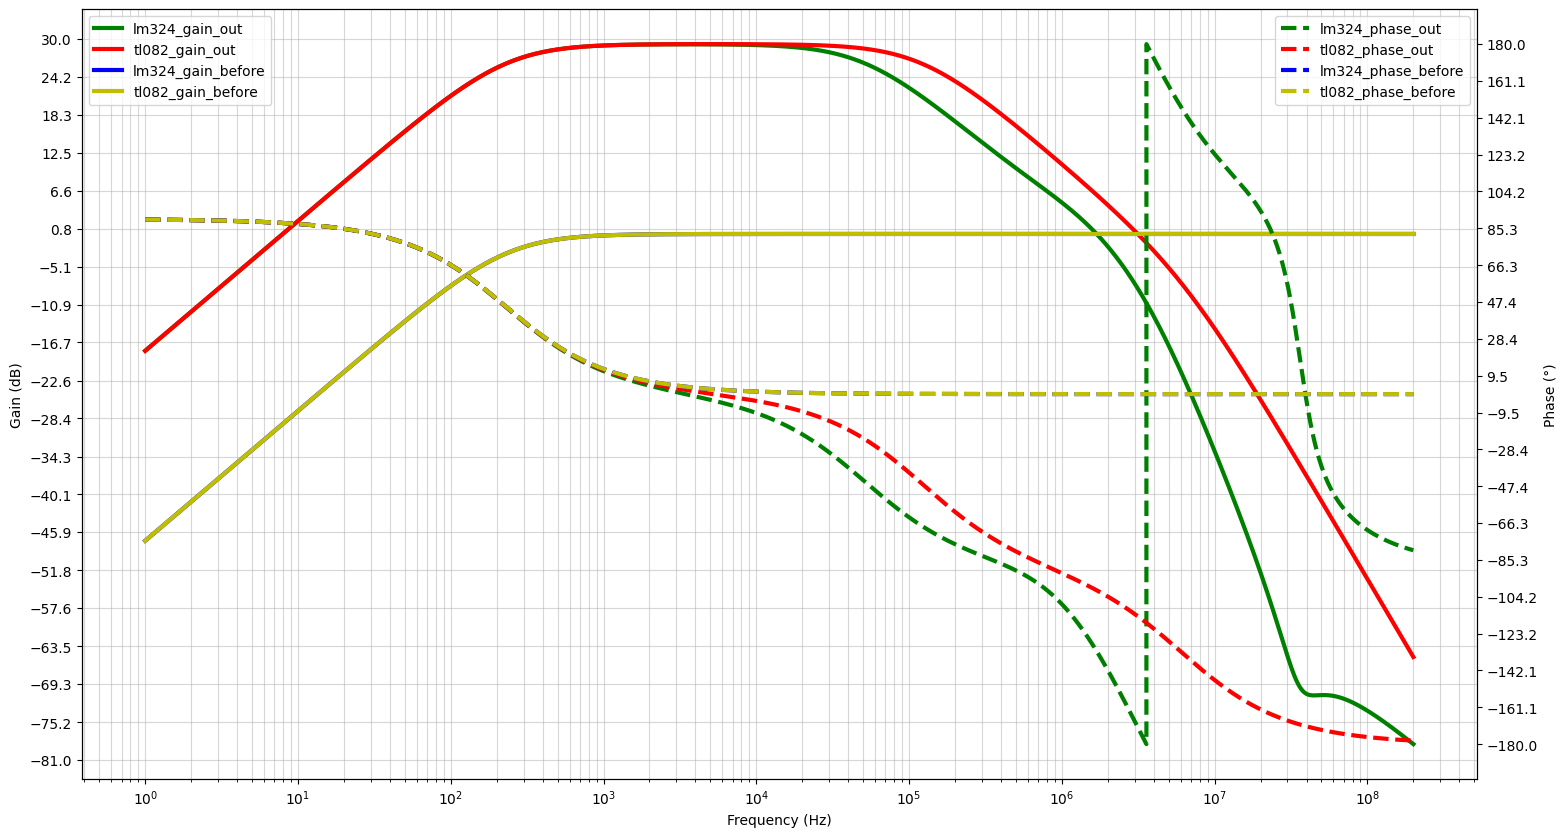

In [13]:
doc = pd.DataFrame(pd.read_csv("./analises/2/2.txt", index_col = "frequency"))

fig, ax = plt.subplots(figsize = (18, 10))

# plot gain
doc.plot(
	ax = ax,
	y = ["lm324_gain_out", "tl082_gain_out", "lm324_gain_before", "tl082_gain_before"],
	color = ["g", "r", "b", "y"],
	lw = 3.0,
)

# plot phases
ax2 = ax.twinx()

doc.plot(
	ax = ax2,
	y = ["lm324_phase_out", "tl082_phase_out", "lm324_phase_before", "tl082_phase_before"],
	style = ["--", "--", "--", "--"],
	color = ["g", "r", "b", "y"],
	lw = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_yticks(np.round(np.linspace(-81, 30, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)
ax.set_xlabel("Frequency (Hz)")


## 3 - Filtro passa-baixa de primeira ordem [gain = 29, cut = 10kHz]

<img src="./analises/3/3.png"/>
<hr/>

Circuito:

	- Ideal:
		C=9.1nF
		R1=1.749kΩ
		R2=1.8114kΩ
		R3=50.72kΩ
	- Comercial:
		C=9.1nF
		R1=1.8kΩ
		R2=1.8kΩ
		R3=51kΩ
Parâmetros:

	- Alimentação do ampop:
		Vcc = 15V Vee = -15V
	- Sinal de entrada:
		Vpp = 100mV
		Fase = 0°
Análise:

	- Transiente:
		De 1Hz até 200MHz

<hr />

- Gain Theoretical: 29.248 db
- Gain Theoretical: 29


- Gain TL082: 29.247 db
- Gain TL082: 28.996


- Gain LM324: 29.245 db
- Gain LM324: 28.99


Cutoff frequency theoretical: 10 kHz
Cutoff frequency TL082: 9.9073 kHz
Cutoff frequency LM324: 9.6194 kHz


Cutoff frequency phase theoretical: -45°
Cutoff frequency phase TL082: -49.513°
Cutoff frequency phase LM324: -54.66°


Attenuation ratio theoretical: 20 db/dec
Attenuation ratio TL082: 38.962 db/dec
Attenuation ratio LM324: 38.98 db/dec


Cutoff frequency gain theoretical: 26.248 db
Cutoff frequency gain TL082: 26.247 db
Cutoff frequency gain LM324: 26.246 db


Text(0.5, 0, 'Frequency (Hz)')

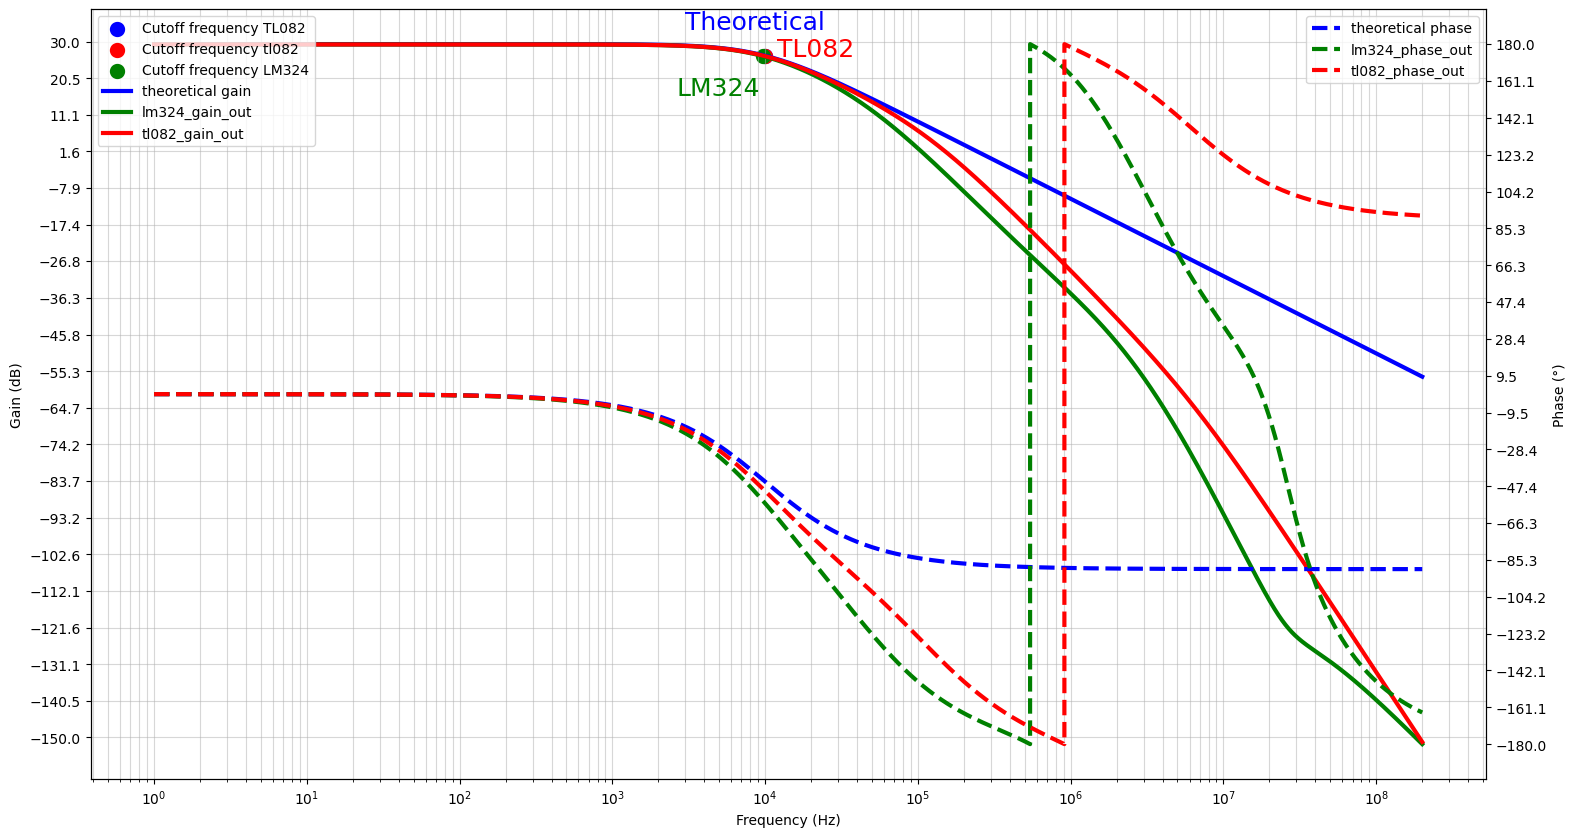

In [14]:
doc = pd.DataFrame(pd.read_csv("./analises/3/3.txt", index_col = "frequency"))

linear_gain_theoretical = 29
gain_theoretical = linear_2_log(linear_gain_theoretical)
gain_tl082 = get_gain(doc, "tl082_gain_out")
gain_lm324 = get_gain(doc, "lm324_gain_out")

cutoff_frequency_theoretical = 10e3
cutoff_frequency_tl082 = get_cutoff_frequency(doc, "tl082_gain_out")
cutoff_frequency_lm324 = get_cutoff_frequency(doc, "lm324_gain_out")

attenuation_ratio_tl082 = get_attenuation_ratio(doc, "tl082_gain_out", False)
attenuation_ratio_lm324 = get_attenuation_ratio(doc, "lm324_gain_out", False)

# Create transfer function of the theoretical behavior 
theoretical_tf = get_n1_low_pass_filter(cutoff_frequency_theoretical, gain_theoretical)

print_param("- Gain Theoretical", gain_theoretical, "db")
print_param("- Gain Theoretical", linear_gain_theoretical, "")
print("\n")
print_param("- Gain TL082", gain_tl082, "db")
print_param("- Gain TL082", log_2_linear(gain_tl082), "")
print("\n")
print_param("- Gain LM324", gain_lm324, "db")
print_param("- Gain LM324", log_2_linear(gain_lm324), "")
print("\n")
print_param("Cutoff frequency theoretical", cutoff_frequency_theoretical, "Hz")
print_param("Cutoff frequency TL082", cutoff_frequency_tl082, "Hz")
print_param("Cutoff frequency LM324", cutoff_frequency_lm324, "Hz")
print("\n")
print_param("Cutoff frequency phase theoretical", -45, "°")
print_param("Cutoff frequency phase TL082", doc.loc[cutoff_frequency_tl082]["tl082_phase_out"], "°")
print_param("Cutoff frequency phase LM324", doc.loc[cutoff_frequency_lm324]["lm324_phase_out"], "°")
print("\n")
print_param("Attenuation ratio theoretical", 20, "db/dec")
print_param("Attenuation ratio TL082", attenuation_ratio_tl082, "db/dec")
print_param("Attenuation ratio LM324", attenuation_ratio_lm324, "db/dec")
print("\n")
print_param("Cutoff frequency gain theoretical", gain_theoretical - 3, "db")
print_param("Cutoff frequency gain TL082", doc.loc[cutoff_frequency_tl082]["tl082_gain_out"], "db")
print_param("Cutoff frequency gain LM324", doc.loc[cutoff_frequency_lm324]["lm324_gain_out"], "db")

fig, ax = plt.subplots(figsize = (18, 10))

mag, phase, omega = theoretical_tf.frequency_response(2 * np.pi * doc.index)

freq = omega / (2 * np.pi)

# Plot cutoff frequencies
# Theoretical
ax.scatter(
	x = cutoff_frequency_theoretical,
	y = get_cutoff_gain(gain_theoretical),
	label = "Cutoff frequency TL082",
	color = 'b',
	linewidths = 5
)
ax.annotate(
	"Theoretical",
	(cutoff_frequency_theoretical - 7000, get_cutoff_gain(gain_theoretical) + 7),
	color = 'b',
	fontsize = 18
)
# TL082
ax.scatter(
	x = cutoff_frequency_tl082,
	y = get_cutoff_gain(gain_tl082),
	label = "Cutoff frequency tl082",
	color = 'r',
	linewidths = 5
)
ax.annotate(
	"TL082",
	(cutoff_frequency_tl082 + 2000, get_cutoff_gain(gain_tl082)),
	color = 'r',
	fontsize = 18
)
# LM324
ax.scatter(
	x = cutoff_frequency_lm324,
	y = get_cutoff_gain(gain_lm324),
	label = "Cutoff frequency LM324",
	color = 'g',
	linewidths = 5
)
ax.annotate(
	'LM324',
	(cutoff_frequency_lm324 - 7000, get_cutoff_gain(gain_lm324) - 10),
	color = 'g',
	fontsize = 18
)

# plot gain
ax.plot(
	freq,
	linear_2_log(mag),
	label = "theoretical gain",
	color = "b",
	linewidth = 3.0)

doc.plot(
	ax = ax,
	y = ["lm324_gain_out", "tl082_gain_out"],
	color = ["g", "r"],
	lw = 3.0,
)

# plot phases
ax2 = ax.twinx()

ax2.plot(
	freq,
	np.rad2deg(np.array(phase)),
	label = "theoretical phase",
	color = "b",
	linestyle = "--",
	linewidth = 3.0
)

doc.plot(
	ax = ax2,
	y = ["lm324_phase_out", "tl082_phase_out"],
	style = ["--", "--"],
	color = ["g", "r"],
	lw = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_yticks(np.round(np.linspace(30, -150, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)
ax.set_xlabel("Frequency (Hz)")


### Ganho antes da parte ativa

Text(0.5, 0, 'Frequency (Hz)')

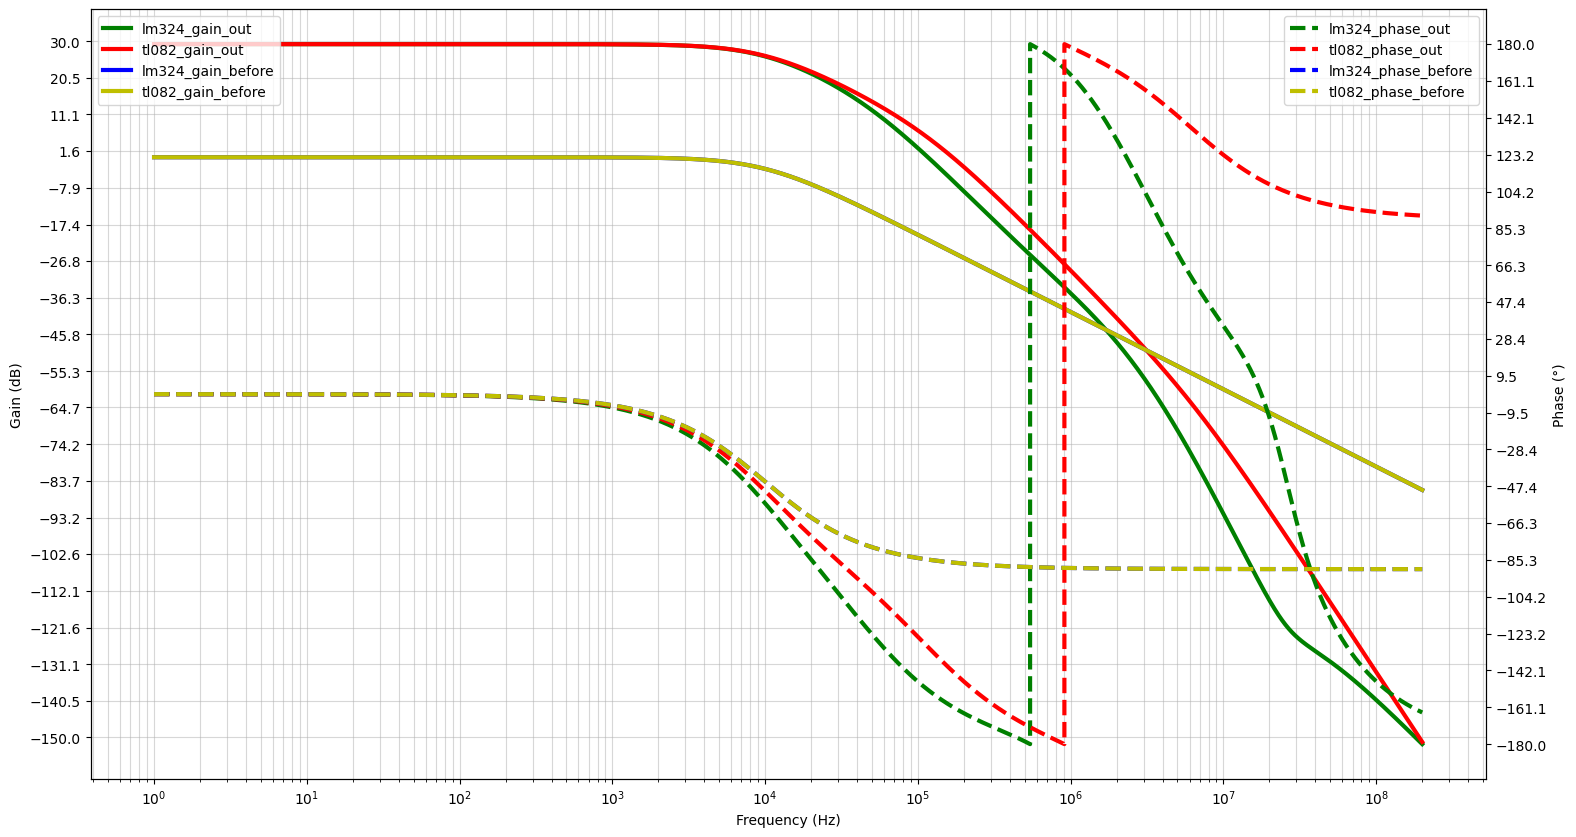

In [15]:
doc = pd.DataFrame(pd.read_csv("./analises/3/3.txt", index_col = "frequency"))

fig, ax = plt.subplots(figsize = (18, 10))

# plot gain
doc.plot(
	ax = ax,
	y = ["lm324_gain_out", "tl082_gain_out", "lm324_gain_before", "tl082_gain_before"],
	color = ["g", "r", "b", "y"],
	lw = 3.0,
)

# plot phases
ax2 = ax.twinx()

doc.plot(
	ax = ax2,
	y = ["lm324_phase_out", "tl082_phase_out", "lm324_phase_before", "tl082_phase_before"],
	style = ["--", "--", "--", "--"],
	color = ["g", "r", "b", "y"],
	lw = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_yticks(np.round(np.linspace(30, -150, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)
ax.set_xlabel("Frequency (Hz)")


## 4 - Filtro passa-baixa de terceira ordem [gain = 29, cut = 10kHz] (VCVS)

<img src="./analises/4/4.png"/>
<hr/>

### Estágio 1 (Passa baixa de 2° ordem)

Circuito:

	- Ideal:
		C1=3.326nF
		C2=750pF
		R1=142.12kΩ
		R2=851.39Ω
		R3=175.41kΩ
		R4=773.24kΩ

	- Comercial:
		C1=3.3nF
		C2=750pF
		R1=150kΩ
		R2=820Ω
		R3=180kΩ
		R4=510kΩ

### Estágio 2 (Passa baixa de 1° ordem)

Circuito:

	- Ideal:
		C1=91nF
		R1=174.9Ω
		R2=214.57Ω
		R3=945.86Ω

	- Comercial:
		C1=91nF
		R1=180Ω
		R2=220Ω
		R3=910Ω

### Simulação

Parâmetros:

	- Alimentação do ampop:
		Vcc = 15V Vee = -15V
	- Sinal de entrada:
		Vpp = 100mV
		Fase = 0°
Análise:

	- Transiente:
		De 1Hz até 200MHz

<hr />

- Gain Theoretical: 29.248 db
- Gain Theoretical: 29


- Gain TL082: 29.428 db
- Gain TL082: 29.608


- Gain LM324: 29.443 db
- Gain LM324: 29.66


Cutoff frequency theoretical: 10 kHz
Cutoff frequency TL082: 9.935 kHz
Cutoff frequency LM324: 7.0631 kHz


Cutoff frequency phase theoretical: 134.98°
Cutoff frequency phase TL082: 140.22°
Cutoff frequency phase LM324: 91.661°


Attenuation ratio theoretical: 53.28 db/dec
Attenuation ratio TL082: 52.045 db/dec
Attenuation ratio LM324: 43.827 db/dec


Cutoff frequency gain theoretical: 26.248 db
Cutoff frequency gain TL082: 26.435 db
Cutoff frequency gain LM324: 26.453 db


Text(0.5, 0, 'Frequency (Hz)')

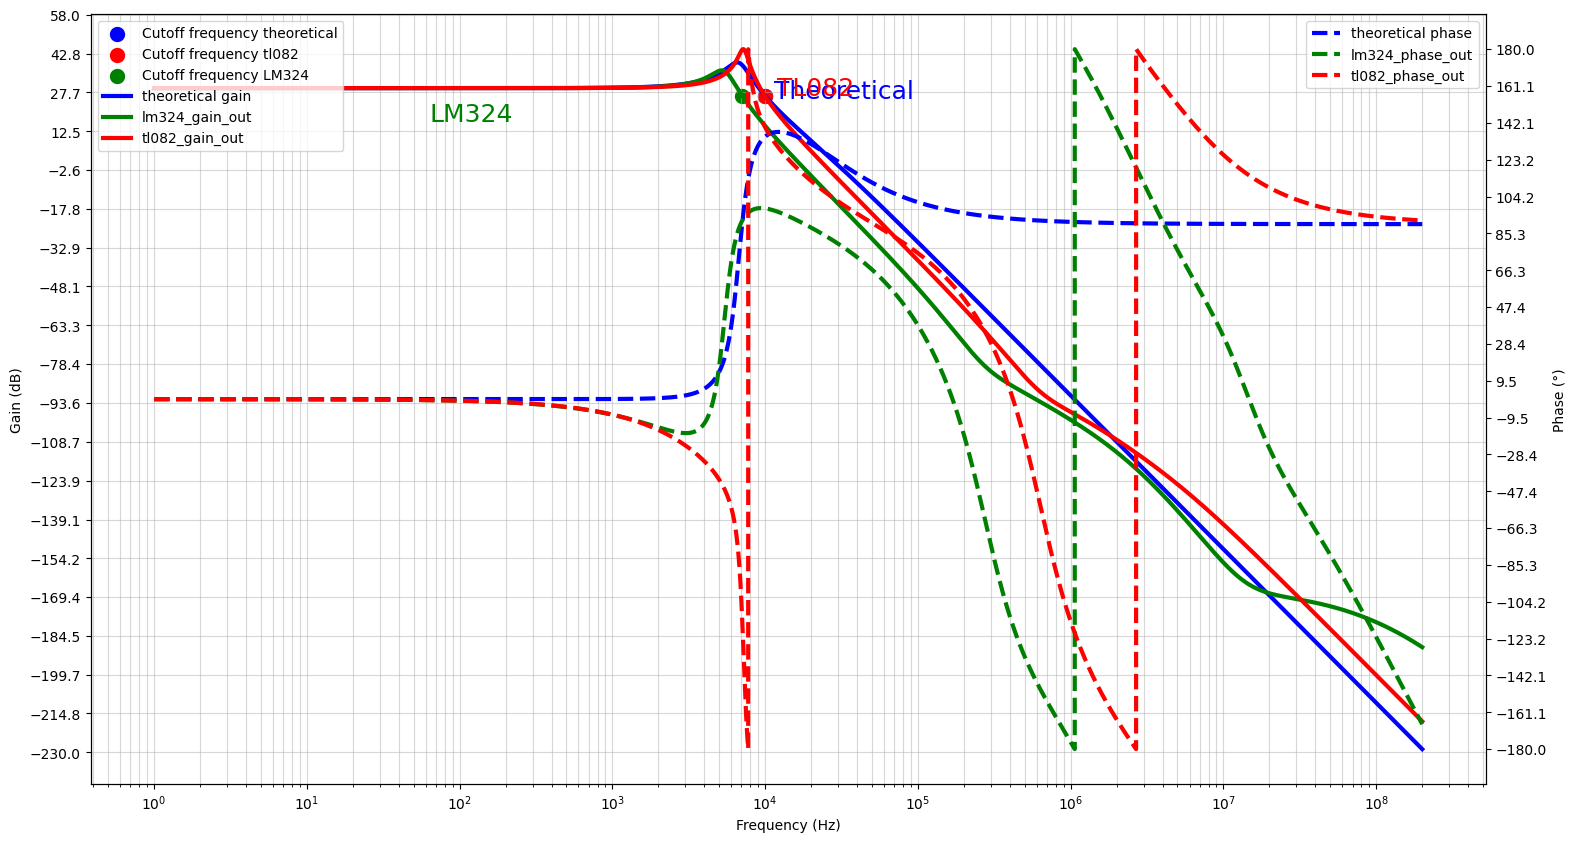

In [16]:
doc = pd.DataFrame(pd.read_csv("./analises/4/4.txt", index_col = "frequency"))

linear_gain_theoretical = 29
gain_theoretical = linear_2_log(linear_gain_theoretical)
gain_tl082 = get_gain_in_range(doc, "tl082_gain_out", 10, 1000)
gain_lm324 = get_gain_in_range(doc, "lm324_gain_out", 10, 1000)

cutoff_frequency_theoretical = 10e3
cutoff_frequency_tl082 = get_cutoff_frequency_in_range(doc, "tl082_gain_out", 10, 1000)
cutoff_frequency_lm324 = get_cutoff_frequency_in_range(doc, "lm324_gain_out", 10, 1000)

# Create transfer function of the theoretical behavior 
theoretical_tf = get_n3_low_pass_filter(10 ** 4, gain_theoretical, 1)

mag, phase, omega = theoretical_tf.frequency_response(2 * np.pi * doc.index)

freq = omega / (2 * np.pi)

theoretical_data = pd.DataFrame(
	{ "frequency": omega / 2 * np.pi, "gain": linear_2_log(mag), "phase": np.rad2deg(phase) }
).set_index("frequency")

attenuation_ratio_theoretical = get_attenuation_ratio(theoretical_data, "gain", False)
attenuation_ratio_tl082 = get_attenuation_ratio(doc, "tl082_gain_out", False)
attenuation_ratio_lm324 = get_attenuation_ratio(doc, "lm324_gain_out", False)

print_param("- Gain Theoretical", gain_theoretical, "db")
print_param("- Gain Theoretical", linear_gain_theoretical, "")
print("\n")
print_param("- Gain TL082", gain_tl082, "db")
print_param("- Gain TL082", log_2_linear(gain_tl082), "")
print("\n")
print_param("- Gain LM324", gain_lm324, "db")
print_param("- Gain LM324", log_2_linear(gain_lm324), "")
print("\n")
print_param("Cutoff frequency theoretical", cutoff_frequency_theoretical, "Hz")
print_param("Cutoff frequency TL082", cutoff_frequency_tl082, "Hz")
print_param("Cutoff frequency LM324", cutoff_frequency_lm324, "Hz")
print("\n")
print_param("Cutoff frequency phase theoretical", theoretical_data.loc[get_cutoff_frequency_in_range(theoretical_data, "gain", 10, 1000)]["phase"], "°")
print_param("Cutoff frequency phase TL082", doc.loc[cutoff_frequency_tl082]["tl082_phase_out"], "°")
print_param("Cutoff frequency phase LM324", doc.loc[cutoff_frequency_lm324]["lm324_phase_out"], "°")
print("\n")
print_param("Attenuation ratio theoretical", attenuation_ratio_theoretical, "db/dec")
print_param("Attenuation ratio TL082", attenuation_ratio_tl082, "db/dec")
print_param("Attenuation ratio LM324", attenuation_ratio_lm324, "db/dec")
print("\n")
print_param("Cutoff frequency gain theoretical", gain_theoretical - 3, "db")
print_param("Cutoff frequency gain TL082", doc.loc[cutoff_frequency_tl082]["tl082_gain_out"], "db")
print_param("Cutoff frequency gain LM324", doc.loc[cutoff_frequency_lm324]["lm324_gain_out"], "db")

fig, ax = plt.subplots(figsize = (18, 10))

# Plot cutoff frequencies
# Theoretical
ax.scatter(
	x = cutoff_frequency_theoretical,
	y = get_cutoff_gain(gain_theoretical),
	label = "Cutoff frequency theoretical",
	color = 'b',
	linewidths = 5
)
ax.annotate(
	"Theoretical",
	(cutoff_frequency_theoretical + 1500, get_cutoff_gain(gain_theoretical) - 1),
	color = 'b',
	fontsize = 18
)
# TL082
ax.scatter(
	x = cutoff_frequency_tl082,
	y = get_cutoff_gain(gain_tl082),
	label = "Cutoff frequency tl082",
	color = 'r',
	linewidths = 5
)
ax.annotate(
	"TL082",
	(cutoff_frequency_tl082 + 2000, get_cutoff_gain(gain_tl082)),
	color = 'r',
	fontsize = 18
)
# LM324
ax.scatter(
	x = cutoff_frequency_lm324,
	y = get_cutoff_gain(gain_lm324),
	label = "Cutoff frequency LM324",
	color = 'g',
	linewidths = 5
)
ax.annotate(
	'LM324',
	(cutoff_frequency_lm324 - 7000, get_cutoff_gain(gain_lm324) - 10),
	color = 'g',
	fontsize = 18
)

# plot gain
ax.plot(
	freq,
	linear_2_log(mag),
	label = "theoretical gain",
	color = "b",
	linewidth = 3.0
)

doc.plot(
	ax = ax,
	y = ["lm324_gain_out", "tl082_gain_out"],
	color = ["g", "r"],
	lw = 3.0,
)

# plot phases
ax2 = ax.twinx()

ax2.plot(
	freq,
	np.rad2deg(np.array(phase)),
	label = "theoretical phase",
	color = "b",
	linestyle = "--",
	linewidth = 3.0
)

doc.plot(
	ax = ax2,
	y = ["lm324_phase_out", "tl082_phase_out"],
	style = ["--", "--"],
	color = ["g", "r"],
	lw = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_yticks(np.round(np.linspace(58, -230, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)
ax.set_xlabel("Frequency (Hz)")


### Comparação entre item 1 e 2 (Influência do ganho)

Text(0.5, 0, 'Frequency (Hz)')

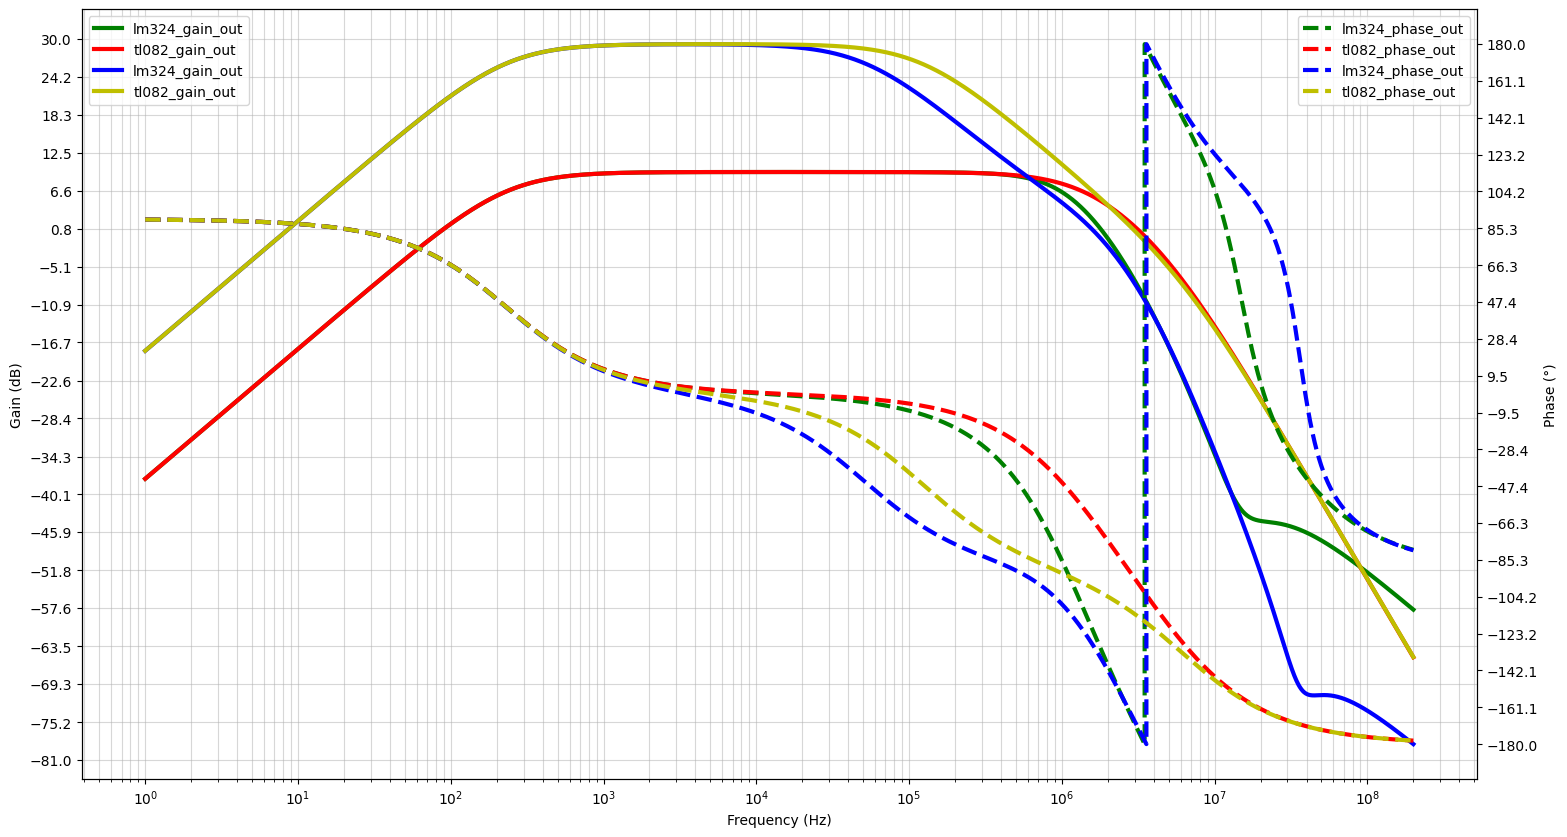

In [17]:
doc = pd.DataFrame(pd.read_csv("./analises/1/1.txt", index_col = "frequency"))
doc2 = pd.DataFrame(pd.read_csv("./analises/2/2.txt", index_col = "frequency"))

fig, ax = plt.subplots(figsize = (18, 10))

# plot gain
doc.plot(
	ax = ax,
	y = ["lm324_gain_out", "tl082_gain_out"],
	color = ["g", "r"],
	lw = 3.0,
)
doc2.plot(
	ax = ax,
	y = ["lm324_gain_out", "tl082_gain_out"],
	color = ["b", "y"],
	lw = 3.0,
)

# plot phases
ax2 = ax.twinx()
doc.plot(
	ax = ax2,
	y = ["lm324_phase_out", "tl082_phase_out"],
	style = ["--", "--"],
	color = ["g", "r"],
	lw = 3.0
)
doc2.plot(
	ax = ax2,
	y = ["lm324_phase_out", "tl082_phase_out"],
	style = ["--", "--"],
	color = ["b", "y"],
	lw = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_yticks(np.round(np.linspace(-81, 30, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)
ax.set_xlabel("Frequency (Hz)")